In [102]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # Can be used for initial split if careful
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping # Optional

# Load the dataset
df = pd.read_csv('baraj_seviyesi_tum_yillar_eksiksiz.csv', index_col=0, parse_dates=True)

# Keep only the target variable for univariate forecasting initially
# (You can add features later)
df_lstm = df[['Baraj_Seviyesi']].copy()

print(len(df_lstm))


3396


In [103]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)

# Keep the scaler object
# scaler will be used later for inverse transformation

In [104]:
# Define sequence length
sequence_length = 30 # Look back 30 days to predict the next day

X_seq, y_seq = [], []
for i in range(sequence_length, len(scaled_data)):
    X_seq.append(scaled_data[i-sequence_length:i, 0]) # Input sequence
    y_seq.append(scaled_data[i, 0]) # Target value (next day)

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Reshape X for LSTM input: [samples, time steps, features]
# In this univariate case, features = 1
X_seq = np.reshape(X_seq, (X_seq.shape[0], X_seq.shape[1], 1))

In [105]:
# Define split point (70% for training, 10% for validation, 20% for testing)
train_size = int(len(X_seq) * 0.70)
val_size = int(len(X_seq) * 0.10)
test_size = len(X_seq) - train_size - val_size

# Split data into train, validation, and test sets
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size+val_size]
y_val = y_seq[train_size:train_size+val_size]

X_test = X_seq[train_size+val_size:]
y_test = y_seq[train_size+val_size:]

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Testing sequences: {X_test.shape}")


Training sequences: (2356, 30, 1)
Validation sequences: (336, 30, 1)
Testing sequences: (674, 30, 1)


In [106]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2)) # Dropout for regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25)) # Optional intermediate dense layer
model.add(Dense(units=1)) # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary() # Print model architecture

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 30, 50)            10400     
                                                                 
 dropout_24 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_25 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_25 (Dropout)        (None, 50)                0         
                                                                 
 dense_24 (Dense)            (None, 25)                1275      
                                                                 
 dense_25 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-tra

Training LSTM model...
Epoch 1/50
10/10 [==============================] - 3s 69ms/step - loss: 0.2062 - val_loss: 0.0494
Epoch 2/50
10/10 [==============================] - 0s 16ms/step - loss: 0.0364 - val_loss: 0.0260
Epoch 3/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0215 - val_loss: 0.0210
Epoch 4/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0171 - val_loss: 0.0135
Epoch 5/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0141 - val_loss: 0.0118
Epoch 6/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0121 - val_loss: 0.0090
Epoch 7/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0101 - val_loss: 0.0076
Epoch 8/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0067
Epoch 9/50
10/10 [==============================] - 0s 16ms/step - loss: 0.0092 - val_loss: 0.0062
Epoch 10/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0084 - val

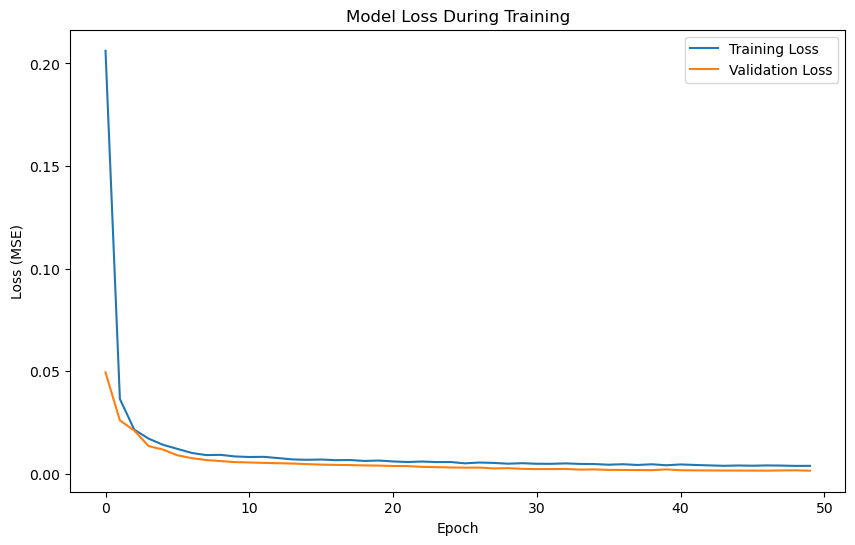

In [107]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
print("Training LSTM model...")
history = model.fit(
    X_train, y_train,
    batch_size=256, # Adjust batch size as needed
    epochs=50,    # Adjust epochs as needed
    validation_data=(X_val, y_val), # Using validation set
    callbacks=[early_stopping],      # Using early stopping
    verbose=1 # Set to 2 for less output per epoch, 0 for silent
)
print("Training complete.")

# Plot training history
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [108]:
# Make predictions on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

22/22 [==============================] - 1s 4ms/step


Test RMSE: 1.0446
Test MAE: 0.7458
Test MAPE: 0.50%
R² Score: 0.9921
Explained Variance: 0.9925


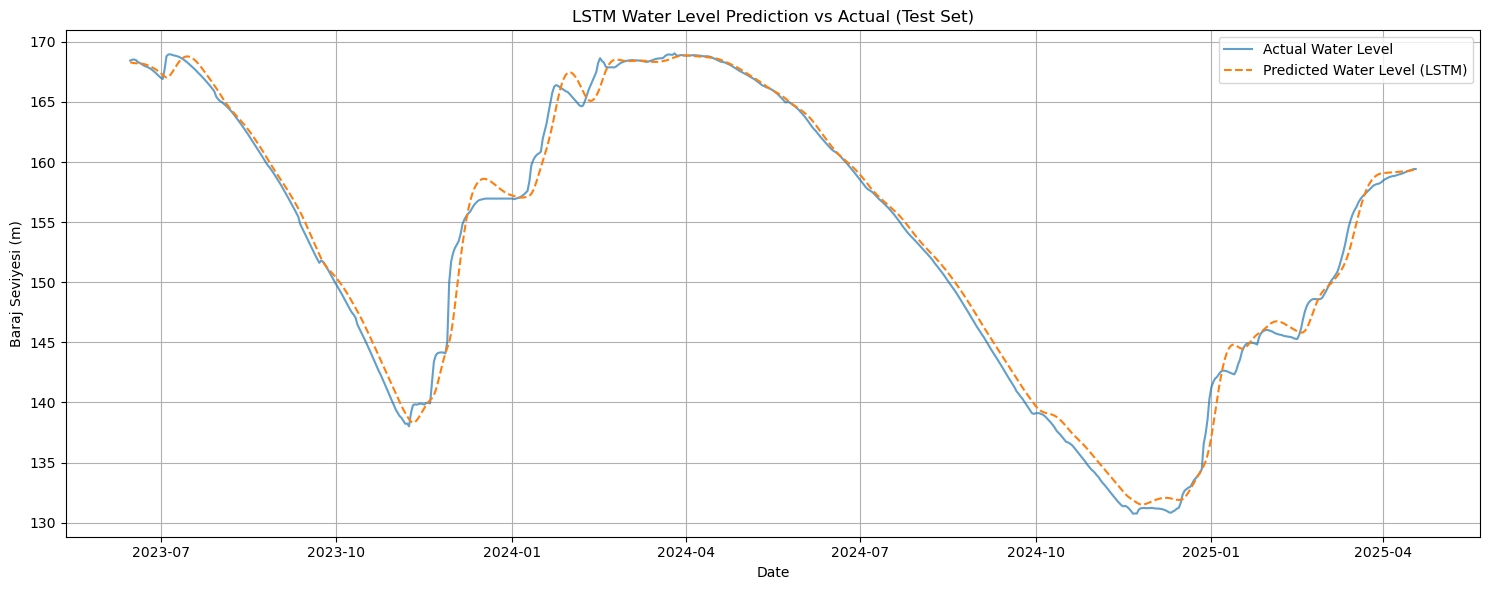

In [109]:
# Calculate metrics on original scale
from sklearn.metrics import r2_score, explained_variance_score


rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred)
explained_variance = explained_variance_score(y_test_actual, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance: {explained_variance:.4f}")

# Instead of:
# test_dates = X_test.index  # This likely doesn't contain date objects

# We should use:
# Get the original dates from the dataframe
# Assuming the total dataset length is len(df_lstm)
# And we've split the data with the last test_size portion for testing
train_val_size = train_size + val_size
test_start_idx = train_val_size + sequence_length
test_end_idx = test_start_idx + len(y_test)
test_dates = df_lstm.index[test_start_idx:test_end_idx]

# Ensure test_dates and prediction arrays have the same length
min_length = min(len(test_dates), len(y_test_actual), len(y_pred))
test_dates = test_dates[:min_length]
y_test_actual = y_test_actual[:min_length]
y_pred = y_pred[:min_length]

# Reshape arrays to ensure compatible dimensions
y_test_actual = y_test_actual.reshape(-1)
y_pred = y_pred.reshape(-1)

# Visualize predictions vs actuals using actual dates
plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_actual, label='Actual Water Level', alpha=0.7)
plt.plot(test_dates, y_pred, label='Predicted Water Level (LSTM)', linestyle='--')
plt.title('LSTM Water Level Prediction vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Baraj Seviyesi (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 24ms/step

Prediction for 2025-04-19:
Predicted Water Level: 159.44 meters


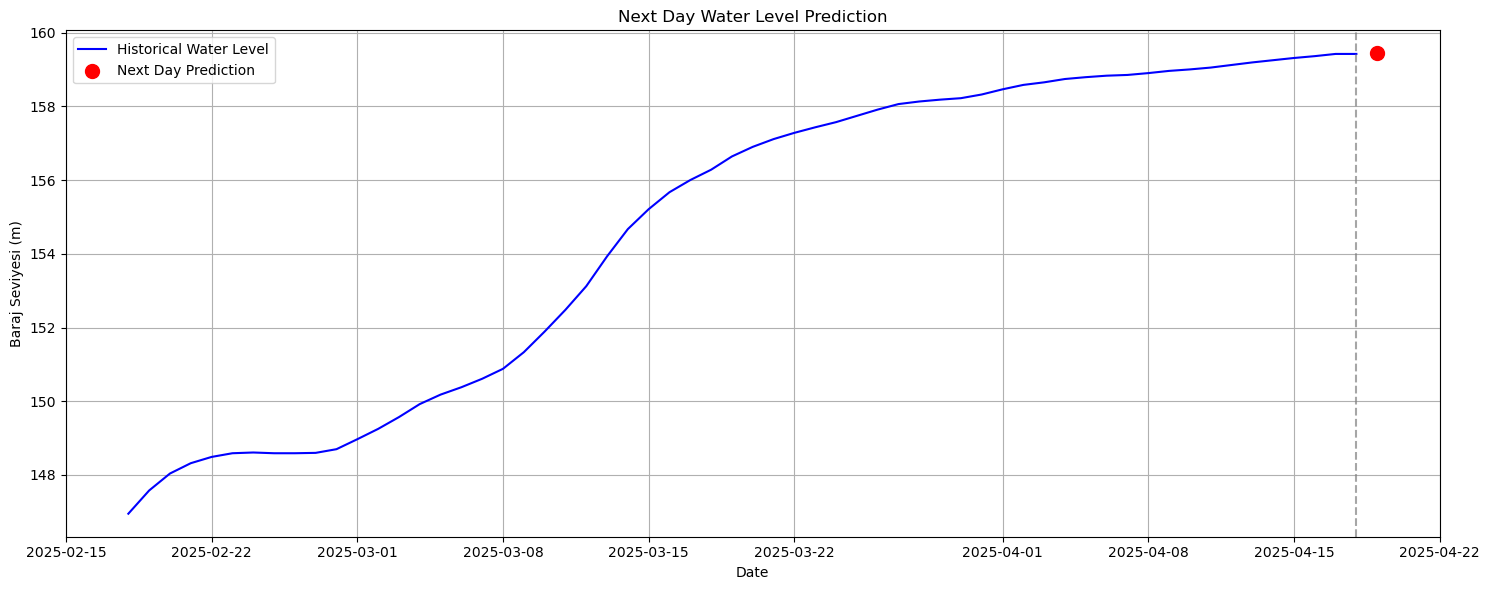

In [112]:
# Predict the next day's water level
# First, get the most recent sequence of data
last_sequence = scaled_data[-sequence_length:]
# Reshape for LSTM input [samples, time steps, features]
last_sequence = last_sequence.reshape(1, sequence_length, 1)

# Make prediction for the next day
next_day_prediction_scaled = model.predict(last_sequence)
# Inverse transform to get the actual water level value
next_day_prediction = scaler.inverse_transform(next_day_prediction_scaled.reshape(-1, 1))[0, 0]

# Get the date for the next day
last_date = df_lstm.index[-1]
next_date = last_date + pd.Timedelta(days=1)

print(f"\nPrediction for {next_date.strftime('%Y-%m-%d')}:")
print(f"Predicted Water Level: {next_day_prediction:.2f} meters")

# Visualize the prediction
plt.figure(figsize=(15, 6))
# Plot the last 60 days of actual data
recent_dates = df_lstm.index[-60:]
recent_values = df_lstm['Baraj_Seviyesi'].values[-60:]

plt.plot(recent_dates, recent_values, label='Historical Water Level', color='blue')
plt.scatter(next_date, next_day_prediction, color='red', s=100, label='Next Day Prediction')

# Add a vertical line to separate historical data from prediction
plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7)

plt.title('Next Day Water Level Prediction')
plt.xlabel('Date')
plt.ylabel('Baraj Seviyesi (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
